In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma
from scipy.stats import multivariate_normal
from scipy.stats import t
import time

# Tests the SCIPY.stats implemented classical samplers

Let us just check if the SCIPY implementations of inverse gamma and multivariate normal make sense

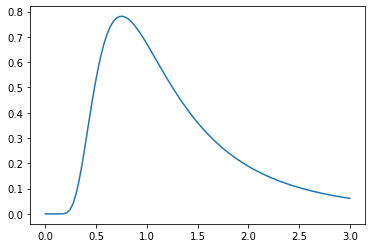

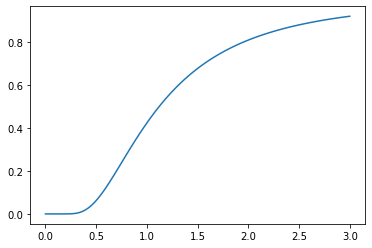

In [9]:
a,b = 3, 3
x = np.linspace(0, 3, 100)
#plots an inverse gamma of scale parameter b (1/rate)
plt.plot(x, invgamma.pdf(x, a, scale  = b))
plt.show()
plt.plot(x,invgamma.cdf(x, a, scale  = b))
plt.show()

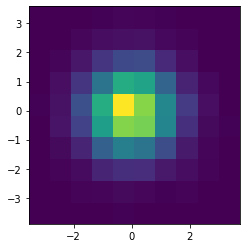

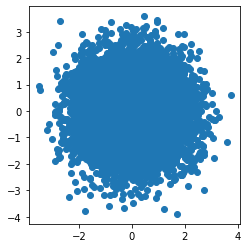

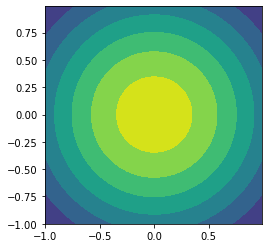

In [11]:
#here we test for a 2d multidimensional normal
cov = np.array([[1,0],[0,1]])
mu = np.zeros(2)

test = multivariate_normal.rvs(mean=mu, cov=cov, size = 10000) #sample the normal
plt.hist2d(test[:,0], test[:,1]) #2d histogram for the normal samples
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
plt.scatter(test[:,0], test[:,1]) #scatter plot for the normal samples
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
x, y = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.dstack((x, y))
plt.contourf(x, y, multivariate_normal.pdf(pos,mean=mu, cov=cov)) #contour plot of the scipy implementation's density
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Defines important functions

In [4]:
def inefficiency_calculator(estimations, k = 20):
    '''
    Computes the inefficiency factor for a general dataset, based on Gemerman/Lopes estimation technique
    Input: data; k = 20, number of batches
    Output: estimation of tau^2/n
    '''
    mean  = np.mean(estimations)
    n =  len(estimations)
    m = int(n/k)
    summation = 0
    
    for j in range(k):
        mean_batch = np.mean(estimations[j*m:(j+1)*m])
        summation += (mean_batch-mean)**2
    
    tau_sqrd_overn = summation/(k*(k-1))
    
    return tau_sqrd_overn

In [5]:
def CI(estimations, k = 20, alpha = 0.95):
    '''
    Calculates alpha assymptotic confidence interval for estimations using a t-distribution
    Input: data; k = 20, number of batches; alpha = 0.95, confidence level
    Output: estimation of assymptotic confidence interval
    '''
    tau_sqrd_overn = inefficiency_calculator(estimations, k = k)
    return np.mean(estimations)-np.sqrt(tau_sqrd_overn)*t.ppf(1-(1-alpha)/2, k-1), np.mean(estimations)+np.sqrt(tau_sqrd_overn)*t.ppf(1-(1-alpha)/2, k-1)

In [6]:
def TracePlot(estimations, skip = 1, interval = False, rang = None, subplot = False):
    '''
    Makes traceplots of MCMC (ergodic means) estimators as a function of number of iterations
    Input: data; skip = 1, how many iterations to skip in calculating t_N, so we calculate t_N*i, where i is the
    iteration; interval = False, if True, plots 95% assymptotic CI; rang = None, if list, restricts the plot 
    only to the rang in the y-axis; subplot = False, if True, returns the plotted values
    Output: if subplot = True, returns the plotted values and plots nothing
    '''
    means = []
    if interval == True:
        upper_bound = []
        lower_bound = []
    
    #only computes means up to skip*i, so if skip = 1, computes the full traceplot
    max_it = int(len(estimations)/skip)
    number_estimations = []
    for i in range(max_it):
        means.append(np.mean(estimations[:i*skip+1]))
        number_estimations.append(i*skip+1)
        
        #if CI is true, computes the assymptotic CI at 95% of confidence
        if interval == True:
            ci = CI(estimations[:i*skip+1])
            lower_bound.append(ci[0])
            upper_bound.append(ci[1])
    
    if subplot == False:
        plt.plot(number_estimations, means)
        plt.plot(number_estimations, np.mean(estimations)*np.ones(len(means)), 'r--')

        #if CI is true, plots the assymptotic confidence region at 95%
        if interval == True:
            plt.plot(number_estimations, lower_bound, linestyle = 'dashed', color = 'orange', linewidth = 0.7)
            plt.plot(number_estimations, upper_bound, linestyle = 'dashed', color = 'orange', linewidth = 0.7)
            plt.fill_between(number_estimations, lower_bound, upper_bound, color = 'orange', alpha = 0.05)
        if rang != None:
            plt.ylim(rang)
        plt.show()
    else:
        return number_estimations, means, np.mean(estimations)*np.ones(len(means))

In [7]:
def ACF(distribution):
    '''
    Estimates the autocorrelation factors for some estimation based on a MCMC method up to 40 lags
    Input: data
    Output: autocorrelation estimations from 0 to 40 lag
    '''
    n = len(distribution)
    mean = np.mean(distribution)
    variance = np.std(distribution)**2

    autocorrelations = []
    for k in range(0, 40):
        sum_k = 0
        for j in range(n-k-1):
            sum_k += (distribution[j]-mean)*(distribution[j+k]-mean) #add the autocorelations between t_N and t_N+lag
        autocorrelations.append(sum_k/((n)*variance))
    return np.array(autocorrelations)

# Simple Gibbs

In [3]:
def SimpleGibbs(yi, m, SSE, a = -1/2, b = 0, number_of_iterations = 1000, burnout = 30, covariances = False):
    '''
    Implements the simple (unblocked) Gibbs to sample from the target distribution, as described in the main work
    Input: yi; m, number of values per class, here assumed to be equal for each class i;
    SSE; a = -1/2, prior parameter; b = 0, prior parameter; number_of_iterations = 1000, iterations per chain;
    burnout = 30, time used in warm up the chain, so that the burnout initial computations are discarded;
    covariances = False, if True, returns the covariances between u and mu
    Output: estimations for the expectations of sigma^2_theta, sigma^2_e, sigma^2_theta/(sigma^2_theta+sigma^2_e)
    If covariances = True, also returns the covariances between u and mu
    '''
    sigmae_estimation = []
    sigmat_estimation = []
    correlation = []
    it = 0
        
    if covariances == True:
        mu_estimation = []
        u_estimation = []
    
    q = len(yi)
    M = q*m
    y_bar = np.mean(yi)
    mu = y_bar
    u = yi - mu
    
    #randomly initialize parameters
    w1 = np.dot(u,u)
    w2 = np.sum(m*(yi-u-mu)**2)
    sigmat = invgamma.rvs(q/2 + a, scale  = (w1/2))
    sigmae = invgamma.rvs(M/2 + b, scale  = ((w2 + SSE)/2))
        
    for iterations in range(number_of_iterations+burnout):
        #update u
        umean = m*(yi-mu)/(m + sigmae/sigmat)
        usigma = sigmae/(m + sigmae/sigmat)*np.identity(q)
        u =  multivariate_normal.rvs(mean = umean, cov =  usigma)

        #update mu
        mumean = np.mean((yi-u))
        musigma = sigmae/M
        mu =  np.random.normal(mumean, np.sqrt(musigma))
        
        #update sigma
        w1 = np.dot(u,u)
        w2 = np.sum(m*(yi-u-mu)**2)
        sigmat = invgamma.rvs(q/2 + a, scale  = (w1/2))
        sigmae = invgamma.rvs(M/2 + b, scale  = ((w2 + SSE)/2))
        
        #takes care of iterations, if above burnout, we consider the points as sampled, otherwise we discard them
        it += 1
        if it >= burnout:
            sigmae_estimation.append(sigmae)
            sigmat_estimation.append(sigmat)
            correlation.append(sigmat/(sigmat+sigmae))
            
            #estimate the covariances
            if covariances == True:
                u_estimation.append(u)
                mu_estimation.append(mu)
    
    if covariances == False:
        return sigmae_estimation, sigmat_estimation, correlation
    else:
        u_estimation = np.array(u_estimation)
        mu_estimation = np.array(mu_estimation)
        mean_u = np.mean(u_estimation, axis = 0)
        mean_mu = np.mean(mu_estimation)
        corr_umu = (np.transpose(u_estimation - mean_u) @ (mu_estimation - mean_mu))/(number_of_iterations*np.std(u_estimation)*np.std(mu_estimation))
        
        return sigmae_estimation, sigmat_estimation, correlation, corr_umu

In [4]:
y_measured = np.array([3.302,4.587,5.052,5.089,4.498,5.186,4.915,4.876,5.262,5.009,5.602,4.336,4.813])
SSE_measured = 14.711

In [10]:
start = time.time()
se, st, cor, correlarion  = SimpleGibbs(y_measured, 3, SSE_measured,  a = -1/2, b = 0, number_of_iterations = 697869, burnout = 30,  covariances = True)
end = time.time()
print(end-start)

123.17455577850342


In [11]:
print('sigma_t= ', np.mean(st), CI(st), 'MCSE= ', inefficiency_calculator(st))
print('sigma_e= ', np.mean(se), CI(se), 'MCSE= ', inefficiency_calculator(se))
print('cor= ', np.mean(cor), CI(cor), 'MCSE= ', inefficiency_calculator(cor))
print('correlation =', correlarion)

sigma_t=  0.18939046438570237 (0.18803109212645291, 0.19074983664495182) MCSE=  4.218211650968421e-07
sigma_e=  0.6190332158832117 (0.6182157258240205, 0.6198507059424029) MCSE=  1.5255151373889477e-07
cor=  0.21221272803093258 (0.21083218106137075, 0.2135932750004944) MCSE=  4.35064787769678e-07
correlation = [-0.22296738 -0.2188134  -0.21871326 -0.21781792 -0.22130936 -0.2190927
 -0.21824491 -0.21844392 -0.21995076 -0.21872663 -0.21903885 -0.21835638
 -0.21933461]


For the traceplots of the simple method, we may not calculate CI, since, as discussed in the main paper, we have no guarantee of geoemtric ergodicity of the chain, and, consequently, of normal assymptocity

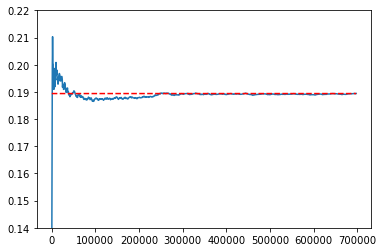

In [12]:
TracePlot(st, skip = 600, rang = [0.14, 0.22], interval = False)

# Blocked Gibbs

In [13]:
def BlockedGibbs(yi, m, SSE, a = -1/2, b = 0, number_of_iterations = 1000, burnout = 30):
     '''
    Implements the blocked Gibbs to sample from the target distribution, as described in the main work
    Input: yi; m, number of values per class, here assumed to be equal for each class i;
    SSE; a = -1/2, prior parameter; b = 0, prior parameter; number_of_iterations = 1000, iterations per chain;
    burnout = 30, time used in warm up the chain, so that the burnout initial computations are discarded;
    Output: estimations for the expectations of sigma^2_theta, sigma^2_e, sigma^2_theta/(sigma^2_theta+sigma^2_e)
    If covariances = True, also returns the covariances between u and mu
    '''
    sigmae_estimation = []
    sigmat_estimation = []
    correlation = []
    it = 0
    
    q = len(yi)
    M = q*m
    y_bar = np.mean(yi)
    
    theta =  yi
    mu = y_bar
    eta = np.append(mu, theta)
    
    #randomly initialize parameters
    w1 = np.sum((theta-mu)**2)
    w2 = np.sum(m*(yi-theta)**2)
    sigmat = invgamma.rvs(q/2 + a, scale  = (w1/2))
    sigmae = invgamma.rvs(M/2 + b, scale  = ((w2 + SSE)/2))
    
    for iterations in range(number_of_iterations+burnout):
        #update eta
        Etheta = sigmae/(sigmae+m*sigmat)*y_bar+sigmat*m*yi/(sigmae+m*sigmat)
        mean = np.append(y_bar, Etheta)

        #calculates the covariance matrix of eta
        vartheta = sigmae/(sigmae+m*sigmat)*(sigmat+sigmae/M)
        covthetatheta = sigmae**2/(M*(sigmae+m*sigmat))
        covthetamu = sigmae/M

        cov =  np.zeros([q+1,q+1])
        cov[0,0] = (sigmae+m*sigmat)/M
        cov[0,1:] =  np.ones(q)*covthetamu
        cov[1:,0] =  np.ones(q)*covthetamu
        cov[1:,1:] = np.diag((vartheta-covthetatheta)*np.ones(q))+covthetatheta #makes a matriz of diagonal vartheta and off-diaginal covthetatheta
        #estimates eta
        eta = multivariate_normal.rvs(mean = mean, cov =  cov)
        mu, theta =  eta[0], eta[1:]
        
        #update sigma
        w1 = np.dot((theta-mu), (theta-mu))
        w2 = m*np.dot((yi-theta),(yi-theta))
        sigmat = invgamma.rvs(q/2 + a, scale  = (w1/2))
        sigmae = invgamma.rvs(M/2 + b, scale  = ((w2 + SSE)/2))
        
        #takes care of iterations, if above burnout, we consider the points as sampled, otherwise we discard them
        it += 1
        if it >= burnout:
            sigmae_estimation.append(sigmae)
            sigmat_estimation.append(sigmat)
            correlation.append(sigmat/(sigmat+sigmae))
    
    return sigmae_estimation, sigmat_estimation, correlation

In [14]:
start = time.time()
se_blocked, st_blocked, cor_blocked = BlockedGibbs(y_measured, 3, SSE_measured, a = -1/2, b = 0, number_of_iterations = 697869, burnout = 30)
end = time.time()
print(end-start)

148.92396807670593


In [15]:
print('sigma_t= ', np.mean(st_blocked), CI(st_blocked), 'MCSE= ', inefficiency_calculator(st_blocked))
print('sigma_e= ', np.mean(se_blocked), CI(se_blocked), 'MCSE= ', inefficiency_calculator(se_blocked))
print('cor= ', np.mean(cor_blocked), CI(cor_blocked), 'MCSE= ', inefficiency_calculator(cor_blocked))

sigma_t=  0.18804263135700422 (0.18612600416703287, 0.18995925854697557) MCSE=  8.385459209796395e-07
sigma_e=  0.6193134146083094 (0.6183342731624111, 0.6202925560542076) MCSE=  2.1884792293748697e-07
cor=  0.21081110767299285 (0.2087714899350756, 0.2128507254109101) MCSE=  9.496184007291562e-07


C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


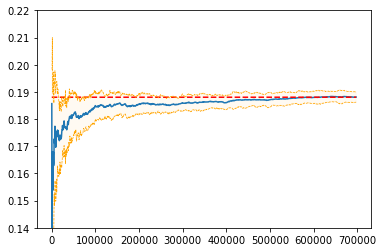

In [16]:
TracePlot(st_blocked, skip = 600, rang = [0.14, 0.22], interval = True)

C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


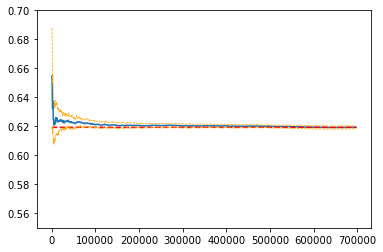

In [17]:
TracePlot(se_blocked, skip = 600, rang = [0.55,0.7], interval = True)

C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


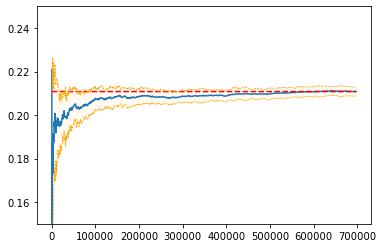

In [18]:
TracePlot(cor_blocked, skip = 600, rang = [0.15, 0.25], interval = True)

# Comparison blocked and unblocked

Let us compare both methods, but for only 10,000 iterations without warm up, as to really access convergence rate

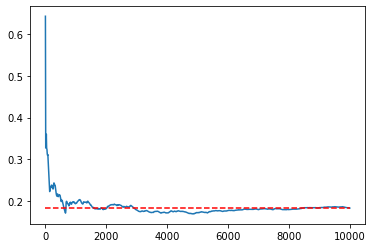

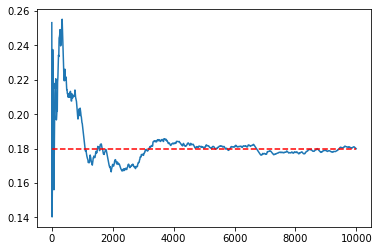

In [19]:
_, st_comp, _  = SimpleGibbs(y_measured, 3, SSE_measured, a = -1/2, b = 0, number_of_iterations = 10000, burnout = 0)
_, st_blocked_comp, _ = BlockedGibbs(y_measured, 3, SSE_measured, a = -1/2, b = 0, number_of_iterations = 10000, burnout = 0)
TracePlot(st_comp, skip = 10, interval = False)
TracePlot(st_blocked_comp, skip = 10, interval = False)

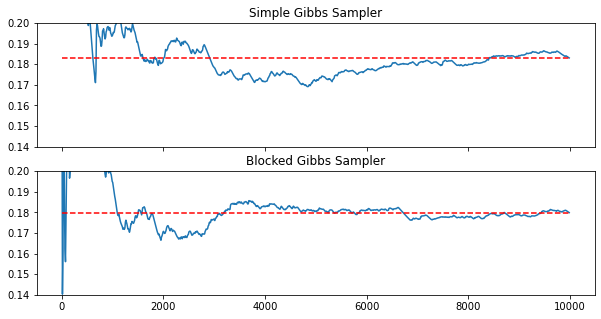

In [20]:
fig, axs = plt.subplots(2, figsize=(10, 5))
axs[0].plot(TracePlot(st_comp, skip = 10, interval = False, subplot = True)[0], TracePlot(st_comp, skip = 10, interval = False, subplot = True)[1])
axs[0].plot(TracePlot(st_comp, skip = 10, interval = False, subplot = True)[0], TracePlot(st_comp, skip = 10, interval = False, subplot = True)[2], 'r--')
axs[0].set_title('Simple Gibbs Sampler')
axs[0].set_ylim([0.14,0.2])
axs[1].plot(TracePlot(st_blocked_comp, skip = 10, interval = False, subplot = True)[0], TracePlot(st_blocked_comp, skip = 10, interval = False, subplot = True)[1])
axs[1].plot(TracePlot(st_blocked_comp, skip = 10, interval = False, subplot = True)[0], TracePlot(st_blocked_comp, skip = 10, interval = False, subplot = True)[2], 'r--')
axs[1].set_title('Blocked Gibbs Sampler')
axs[1].set_ylim([0.14,0.2])
for ax in axs.flat:
    ax.label_outer()
plt.show()

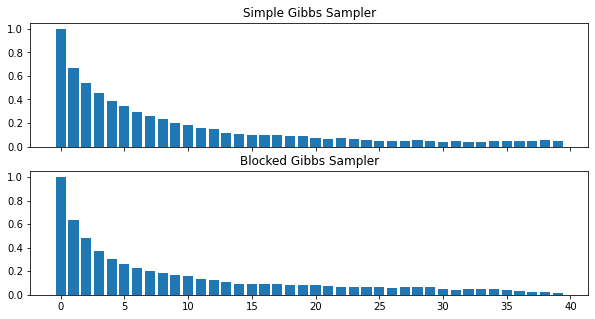

In [21]:
fig, axs = plt.subplots(2, figsize=(10, 5))
axs[0].bar(range(len(ACF(st_comp))), ACF(st_comp)) 
axs[0].set_title('Simple Gibbs Sampler')
axs[1].bar(range(len(ACF(st_blocked_comp))), ACF(st_blocked_comp))
axs[1].set_title('Blocked Gibbs Sampler')
for ax in axs.flat:
    ax.label_outer()

In [22]:
def GelmanSimpleGibbs(yi, m, SSE, number_of_iterations = 1000, number_of_chains = 100):
    '''
    Calculates the Gelman coefficient \hat{R} for the simple (unblocked) Gibbs sampler
    Input: yi; m, number of values per class, here assumed to be equal for each class i;
    SSE; number_of_iterations = 1000, iterations per chain; number_of_chains = 100, number of chains used;
    Output: multi-chain estimation of \hat{R}
    '''
    set_of_chains = np.array(SimpleGibbs(yi, m, SSE,  number_of_iterations = number_of_iterations)[1])
    for chain in range(number_of_chains-1):
        new_chain = np.array(SimpleGibbs(yi, m, SSE,  number_of_iterations = number_of_iterations)[1])
        set_of_chains = np.vstack((set_of_chains, new_chain))
    
    #takes the mean of all chains' entries
    full_mean = np.mean(set_of_chains)
    
    #computes the summation part of the definition of B
    summation_b = 0
    for index in range(number_of_iterations):
        summation_b += (np.mean(set_of_chains[:,index]-full_mean))**2
    #computes B
    b = number_of_iterations/(number_of_chains-1)*summation_b
    
    #computes the summation part of the definition of W
    summation_w = 0
    for index in range(number_of_iterations):
        mean_index  = np.mean(set_of_chains[:,index])             
        for chain in range(number_of_chains):
            summation_w += (set_of_chains[chain,index]-mean_index)**2
    #computes W
    w = 1/(number_of_chains*(number_of_iterations-1))*summation_w
    
    R_hat = np.sqrt(((1-1/number_of_iterations)*w+b/number_of_iterations)/w)
    return R_hat

In [23]:
def GelmanBlockedGibbs(yi, m, SSE, number_of_iterations = 1000, number_of_chains = 100):
    '''
    Calculates the Gelman coefficient \hat{R} for the blocked Gibbs sampler
    Input: yi; m, number of values per class, here assumed to be equal for each class i;
    SSE; number_of_iterations = 1000, iterations per chain; number_of_chains = 100, number of chains used;
    Output: multi-chain estimation of \hat{R}
    '''
    set_of_chains = np.array(BlockedGibbs(yi, m, SSE,  number_of_iterations = number_of_iterations)[1])
    for chain in range(number_of_chains-1):
        new_chain = np.array(BlockedGibbs(yi, m, SSE,  number_of_iterations = number_of_iterations)[1])
        set_of_chains = np.vstack((set_of_chains, new_chain))
    
    #takes the mean of all chains' entries
    full_mean = np.mean(set_of_chains)
    
    #computes the summation part of the definition of B
    summation_b = 0
    for index in range(number_of_iterations):
        summation_b += (np.mean(set_of_chains[:,index]-full_mean))**2
    #computes B
    b = number_of_iterations/(number_of_chains-1)*summation_b
    
    #computes the summation part of the definition of W
    summation_w = 0
    for index in range(number_of_iterations):
        mean_index  = np.mean(set_of_chains[:,index])             
        for chain in range(number_of_chains):
            summation_w += (set_of_chains[chain,index]-mean_index)**2
    #computes W
    w = 1/(number_of_chains*(number_of_iterations-1))*summation_w
    
    R_hat = np.sqrt(((1-1/number_of_iterations)*w+b/number_of_iterations)/w)
    return R_hat

Values of \hat{R}<1.10 are often indications of good convergence for MCMC methods

In [24]:
GelmanSimpleGibbs(y_measured, 3, SSE_measured, number_of_chains = 100), GelmanBlockedGibbs(y_measured, 3, SSE_measured, number_of_chains = 100)

(1.0485849126388498, 1.0491561516392018)

# Blocked Gibbs Matrix Implementation

Here we provide a matrix implementation of the blocked version of the sampler, which is nothing more than the translation of the R code available as supplement to the work of Aixin Tan and James P. Hobert [2009]. This is done simply for computational speed comparison of my own implementation and this more matrix-based code

In [25]:
def BlockedGibbsMatrix(yi, m, SSE, a = -1/2, b = 0, number_of_iterations = 1000, burnout = 30):
    sigmae_estimation = []
    sigmat_estimation = []
    correlation = []
    mean_estimation = []
    it = 0
    
    q = len(yi)
    M = q*m
    y_bar = np.mean(yi)
    
    theta =  yi
    mu = y_bar
    eta = np.append(theta, mu)
    
    #randomly initialize parameters
    matrix = np.append(np.diag(np.ones(q)), -(np.ones((q,1))), axis = 1)
    mm = np.transpose(matrix) @ matrix
    
    w1 = np.transpose(eta) @ mm @ eta
    w2 = m*np.transpose(yi-theta) @ (yi-theta)
    lt = np.random.gamma(q/2 + a, scale  = 1/((w1/2)))
    le = np.random.gamma(M/2 + b, scale  = 1/(((w2 + SSE)/2)))
    
    for iterations in range(number_of_iterations+burnout):
        #update eta
        t = M*lt*le/(lt+m*le)
        d = np.sqrt(lt+m*le)
        invL = np.diag(np.append(np.ones(q)/d,1/np.sqrt(t)))
        invL[-1,:-1] = lt/(d**2*np.sqrt(t))*np.ones(q)
        
        V = np.transpose(invL) @ invL
        etha0 = le*m*V @ np.append(yi, 0)
        eta = np.transpose(etha0)+np.transpose(invL) @ np.transpose(np.random.normal(size = q+1))
        
        #update sigma
        w1 = np.transpose(eta) @ mm @ eta
        w2 = m*np.transpose(yi-eta[:-1]) @ (yi-eta[:-1])
        lt = np.random.gamma(q/2 + a, scale  = 1/((w1/2)))
        le = np.random.gamma(M/2 + b, scale  = 1/(((w2 + SSE)/2)))
        
        #takes care of iterations, if above burnout, we consider the points as sampled, otherwise we discard them
        it += 1
        if it >= burnout:
            se = 1/le
            st = 1/lt
            sigmae_estimation.append(se)
            sigmat_estimation.append(st)
            correlation.append(st/(st + se))
    
    return sigmae_estimation, sigmat_estimation, correlation

In [26]:
start = time.time()
se_matrix, st_matrix, cor_matrix = BlockedGibbsMatrix(y_measured, 3, SSE_measured, a = -1/2, b = 0, number_of_iterations = 697869, burnout = 30)
end = time.time()
print(end-start)

41.855125427246094


Turns out that the matrix version is still much faster than my implementation (about 3 times faster in my machine), but estimations turned out to be still very similar

In [27]:
print('sigma_t= ', np.mean(st_matrix), CI(st_matrix), 'MCSE= ', inefficiency_calculator(st_matrix))
print('sigma_e= ', np.mean(se_matrix), CI(se_matrix), 'MCSE= ', inefficiency_calculator(se_matrix))
print('cor= ', np.mean(cor_matrix), CI(cor_matrix), 'MCSE= ', inefficiency_calculator(cor_matrix))

sigma_t=  0.18908216801974 (0.18740217419906574, 0.19076216184041428) MCSE=  6.4426854664721e-07
sigma_e=  0.6184978166059525 (0.6175078880530466, 0.6194877451588584) MCSE=  2.2369653796333092e-07
cor=  0.2123353741636321 (0.21074367241301664, 0.21392707591424756) MCSE=  5.783289712596858e-07


C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hlovi\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


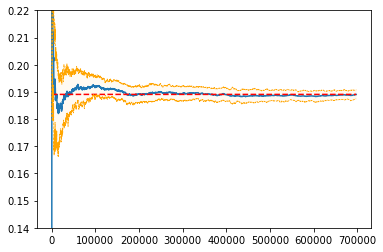

In [28]:
TracePlot(st_matrix, skip = 100, rang = [0.14, 0.22], interval = True)